In [1]:
import warnings
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from helpers import stats as bf
from helpers import regression as pf
from helpers.file import save_file
warnings.filterwarnings("ignore")

Setup Complete


In [ ]:
# Parameters
league = "spain-laliga"
start_season = 2012
random_state = 0
min_games_played = 10
min_games_played_at = 5
filtered_cols = [
    'home_points_pct', 'home_win_pct', 'home_draw_pct', 'home_loss_pct',
    'home_points_pct_last_games', 'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct',
    'home_team_xg', 'home_opp_xg', 'home_team_score', 'home_opp_score',
    'home_home_team_xg', 'home_home_opp_xg', 'home_home_team_score', 'home_home_opp_score',
    'away_points_pct', 'away_win_pct', 'away_draw_pct', 'away_loss_pct',
    'away_points_pct_last_games', 'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct',
    'away_team_xg', 'away_opp_xg', 'away_team_score', 'away_opp_score',
    'away_away_opp_xg', 'away_away_team_xg', 'away_away_opp_score', 'away_away_team_score',
    'home_elo', 'away_elo'
]
filtered_cols=['home_points_pct', 'home_win_pct', 'home_draw_pct', 'home_loss_pct', 'home_points_pct_last_games', 'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct', 'home_team_xg', 'home_opp_xg', 'home_team_score', 'home_opp_score', 'home_home_team_xg', 'home_home_opp_xg', 'home_home_team_score', 'home_home_opp_score', 'away_points_pct', 'away_win_pct', 'away_draw_pct', 'away_loss_pct', 'away_points_pct_last_games', 'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct', 'away_team_xg', 'away_opp_xg', 'away_team_score', 'away_opp_score', 'away_away_opp_xg', 'away_away_team_xg', 'away_away_opp_score', 'away_away_team_score', 'home_odds', 'away_odds', 'draw_odds', 'home_elo', 'away_elo']

filtered_cols.extend([
    "home_ahc_odds",
    "ahc_line",
    "away_ahc_odds",
    "overs_odds",
    "totals_line",
    "unders_odds",
])

preprocess = False

min_odds_1x2 = 2.2
min_odds_ahc = 1.9
min_odds_totals = 1.7

default_value = 1
plot_threshold = 0

voting_models = ["lasso", "ridge",
    # "linear_regression", "svr", "rf_regressor"
]

In [3]:
# Load and prepare matches
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 4940/4940 [00:00<00:00, 7691.82it/s]

Successfully generated teams ELOs.


,season,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,league,...,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds,result,ahc_result,totals_result,home_elo,away_elo
0,2012,2012-08-18,1,Celta Vigo,NaN,0,1,NaN,Málaga,spain-laliga,...,0.25,1.80,2.02,2.50,1.88,A,A,U,1500.00,1500.00
1,2012,2012-08-18,1,Mallorca,NaN,2,1,NaN,Espanyol,spain-laliga,...,0.50,1.82,1.97,2.25,1.93,H,A,O,1500.00,1500.00
2,2012,2012-08-18,1,Sevilla,NaN,2,1,NaN,Getafe,spain-laliga,...,0.75,2.00,2.02,2.50,1.88,H,A,O,1500.00,1500.00
3,2012,2012-08-19,1,Athletic Club,NaN,3,5,NaN,Betis,spain-laliga,...,0.75,1.80,1.97,2.50,1.93,A,A,O,1500.00,1500.00
4,2012,2012-08-19,1,Barcelona,NaN,5,1,NaN,Real Sociedad,spain-laliga,...,2.75,1.95,2.05,3.75,1.85,H,H,O,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2024,2025-05-24,38,Rayo Vallecano,2.2,0,0,0.6,Mallorca,spain-laliga,...,0.75,2.10,1.80,2.00,2.05,D,A,U,1517.41,1490.94
4936,2024,2025-05-24,38,Real Madrid,2.6,2,0,0.8,Real Sociedad,spain-laliga,...,1.25,1.98,1.80,3.00,2.05,H,H,U,1807.22,1526.85
4937,2024,2025-05-25,38,Athletic Club,1.2,0,3,3.5,Barcelona,spain-laliga,...,-0.25,1.98,1.98,3.00,1.88,A,A,P,1689.06,1819.68
4938,2024,2025-05-25,38,Girona,0.0,0,4,2.7,Atlético Madrid,spain-laliga,...,-0.50,1.98,1.98,3.00,1.88,A,A,O,1518.76,1711.87


In [4]:
# Build feature set for regression
data_model = []
for index, game in tqdm(matches.iterrows(), total=len(matches)):
    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict or not away_stats_dict:
        continue
    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "ahc_result",
        "totals_result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
        "home_ahc_odds",
        "ahc_line",
        "away_ahc_odds",
        "overs_odds",
        "totals_line",
        "unders_odds",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}
    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})
data_df = pd.DataFrame(data_model)
display(data_df)

100%|██████████| 4940/4940 [01:45<00:00, 46.85it/s]


,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_score,away_score,home_elo,away_elo,home_ahc_odds,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,1,2,1527.22,1451.53,2.15,0.75,1.78,1.97,2.50,1.93
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,0,3,1479.30,1445.86,1.80,0.25,2.10,2.07,2.50,1.82
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,1,2,1534.66,1467.45,1.85,1.00,2.05,2.02,2.75,1.88
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,3,2,1468.69,1475.38,2.07,0.25,1.82,1.82,2.50,2.07
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,5,3,1471.72,1472.98,2.07,0.50,1.82,1.90,2.25,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,0.459459,0.351351,0.324324,0.324324,0.500000,0.4,0.3,0.3,0.333333,0.388889,...,0,0,1517.41,1490.94,1.78,0.75,2.10,1.80,2.00,2.05
3581,0.729730,0.675676,0.162162,0.162162,0.800000,0.8,0.0,0.2,0.833333,0.055556,...,2,0,1807.22,1526.85,1.88,1.25,1.98,1.80,3.00,2.05
3582,0.630631,0.513514,0.351351,0.135135,0.633333,0.5,0.4,0.1,0.611111,0.333333,...,0,3,1689.06,1819.68,1.88,-0.25,1.98,1.98,3.00,1.88
3583,0.369369,0.297297,0.216216,0.486486,0.266667,0.2,0.2,0.6,0.388889,0.166667,...,0,4,1518.76,1711.87,1.88,-0.50,1.98,1.98,3.00,1.88


In [5]:
last_season = matches.iloc[-1]["season"]

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
for season in tqdm(range(start_season + 1, last_season + 1)):
    matches, trained_models = pf.simulate_with_regression(
        data_df,
        start_season,
        season,
        filtered_cols,
        random_state=0,
        preprocess=preprocess,
        voting_models=voting_models
    )

Training and evaluating models throughout the seasons...


100%|██████████| 12/12 [01:35<00:00,  7.95s/it]



lasso metrics:
Home score -> R²: 0.0957, MAE: 0.8972
Away score -> R²: 0.1025, MAE: 0.8010

voting_regressor metrics:
Home score -> R²: 0.0866, MAE: 0.8993
Away score -> R²: 0.0985, MAE: 0.8037

ridge metrics:
Home score -> R²: 0.0706, MAE: 0.9055
Away score -> R²: 0.0826, MAE: 0.8120

linear_regression metrics:
Home score -> R²: 0.0529, MAE: 0.9116
Away score -> R²: 0.0738, MAE: 0.8158

svr metrics:
Home score -> R²: 0.0695, MAE: 0.8860
Away score -> R²: 0.0507, MAE: 0.8004

rf_regressor metrics:
Home score -> R²: 0.0612, MAE: 0.9189
Away score -> R²: 0.0566, MAE: 0.8217

gradient_boosting metrics:
Home score -> R²: -0.0218, MAE: 0.9504
Away score -> R²: -0.0153, MAE: 0.8548

knn_regressor metrics:
Home score -> R²: -0.0280, MAE: 0.9527
Away score -> R²: -0.0126, MAE: 0.8592

mlp_regressor metrics:
Home score -> R²: -0.0355, MAE: 0.9552
Away score -> R²: -0.0558, MAE: 0.8766

hist_gb metrics:
Home score -> R²: -0.0671, MAE: 0.9750
Away score -> R²: -0.0647, MAE: 0.8814

decision_tree

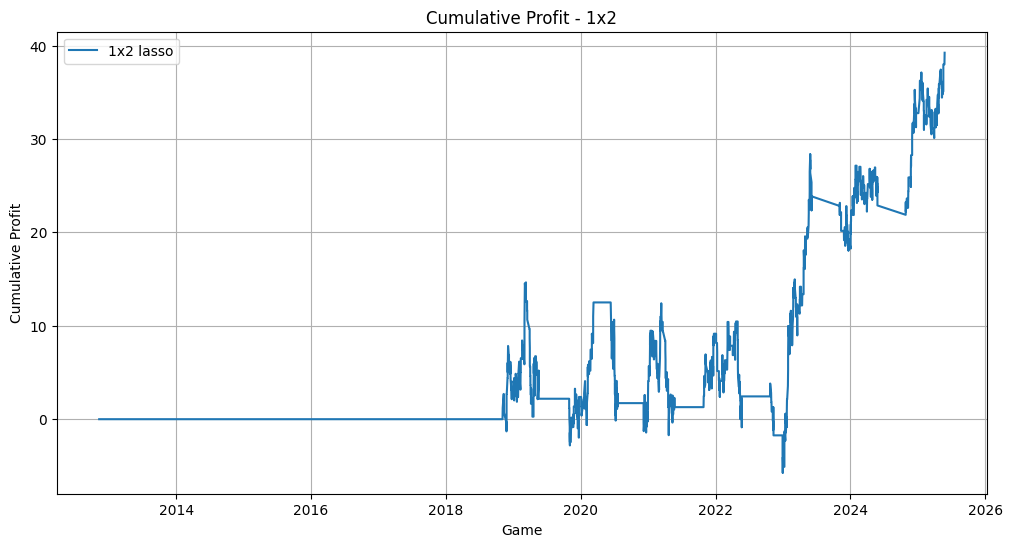

1x2 lasso                --> (  39.23/662): 0.0593
1x2 voting_regressor     --> (  -4.25/661): -0.0064
1x2 gradient_boosting    --> ( -10.15/788): -0.0129
1x2 ridge                --> ( -23.46/674): -0.0348
1x2 decision_tree        --> ( -24.75/921): -0.0269
1x2 hist_gb              --> ( -26.63/845): -0.0315
1x2 svr                  --> (  -27.7/675): -0.041
1x2 rf_regressor         --> ( -28.55/701): -0.0407
1x2 knn_regressor        --> ( -44.43/804): -0.0553
1x2 linear_regression    --> ( -46.38/687): -0.0675
1x2 mlp_regressor        --> ( -82.07/909): -0.0903

Cumulative Profit for AHC market:


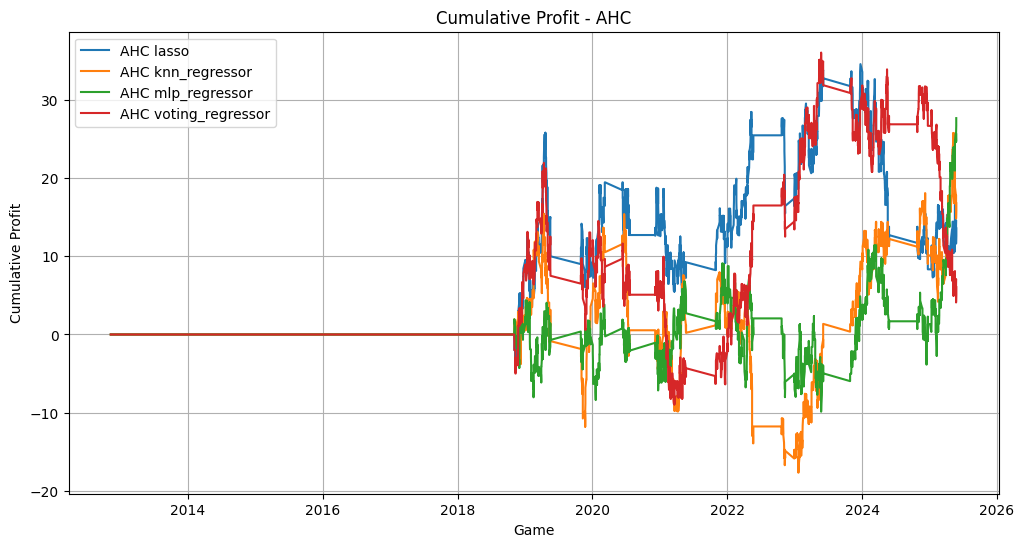

AHC mlp_regressor        --> (  27.69/1208): 0.0229
AHC knn_regressor        --> (   16.8/1190): 0.0141
AHC lasso                --> (  13.59/1210): 0.0112
AHC voting_regressor     --> (   6.06/1212): 0.005
AHC hist_gb              --> (  -9.06/1210): -0.0075
AHC rf_regressor         --> ( -12.08/1194): -0.0101
AHC svr                  --> ( -17.66/1206): -0.0146
AHC gradient_boosting    --> ( -22.63/1201): -0.0188
AHC decision_tree        --> ( -32.98/1150): -0.0287
AHC ridge                --> ( -34.68/1197): -0.029
AHC linear_regression    --> ( -53.99/1195): -0.0452

Cumulative Profit for Totals market:


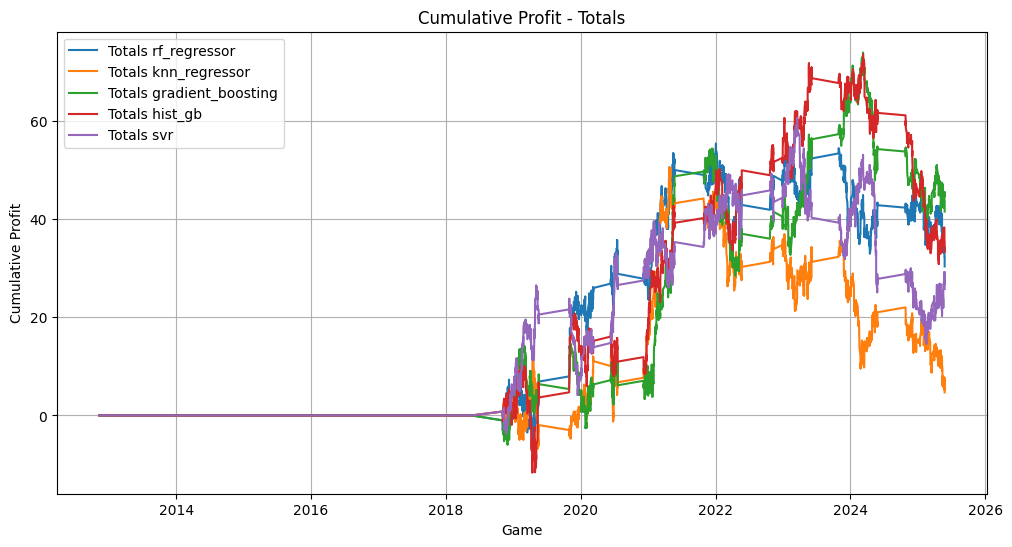

Totals gradient_boosting    --> (   41.5/1793): 0.0231
Totals hist_gb              --> (  33.27/1791): 0.0186
Totals rf_regressor         --> (  30.33/1786): 0.017
Totals svr                  --> (  25.76/1791): 0.0144
Totals knn_regressor        --> (   4.69/1792): 0.0026
Totals decision_tree        --> (   -0.5/1769): -0.0003
Totals lasso                --> (  -4.48/1789): -0.0025
Totals voting_regressor     --> (  -8.84/1790): -0.0049
Totals mlp_regressor        --> (  -22.8/1792): -0.0127
Totals linear_regression    --> ( -29.29/1791): -0.0164
Totals ridge                --> ( -39.63/1790): -0.0221


,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,ProfitAHC_svr,CumulativeProfitAHC_svr,ProfitTotals_svr,CumulativeProfitTotals_svr,Profit1x2_voting_regressor,CumulativeProfit1x2_voting_regressor,ProfitAHC_voting_regressor,CumulativeProfitAHC_voting_regressor,ProfitTotals_voting_regressor,CumulativeProfitTotals_voting_regressor
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,0.459459,0.351351,0.324324,0.324324,0.500000,0.4,0.3,0.3,0.333333,0.388889,...,0.0,-16.66,-1.00,26.71,0.00,-5.50,0.00,4.10,-1.00,-7.82
3581,0.729730,0.675676,0.162162,0.162162,0.800000,0.8,0.0,0.2,0.833333,0.055556,...,0.0,-16.66,1.05,27.76,0.00,-5.50,0.00,4.10,-1.00,-8.82
3582,0.630631,0.513514,0.351351,0.135135,0.633333,0.5,0.4,0.1,0.611111,0.333333,...,0.0,-16.66,0.00,27.76,1.25,-4.25,0.98,5.08,0.00,-8.82
3583,0.369369,0.297297,0.216216,0.486486,0.266667,0.2,0.2,0.6,0.388889,0.166667,...,-1.0,-17.66,-1.00,26.76,0.00,-4.25,0.98,6.06,0.98,-7.84


In [ ]:
pf.get_regression_simulation_results(
    matches,
    trained_models.keys(),
    plot_threshold,
    default_value,
    min_odds_1x2=min_odds_1x2,
    min_odds_ahc=min_odds_ahc,
    min_odds_totals=min_odds_totals,
)